In [1]:
import glob
import os
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

In [2]:
all_files = glob.glob("data/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, thousands=',')
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
# Check for null data
df.isnull().sum()

rank        0
program     0
network     0
time        0
duration    0
rating      0
viewers     0
date        0
dtype: int64

In [4]:
df['program'] = df['program'].str.split(':').str[0]
df['year'] = pd.DatetimeIndex(df['date']).year

In [5]:
df['category'] = 'Other'
df['category'] = df.apply(lambda x: 'News' if x.network in (['FOX NEWS CHANNEL', 'MSNBC', 'CNN', 'NEWSMAX TV', 'FOX BUSINESS NETWORK', 'CNBC']) else x.category, axis=1)
df['category'] = df.apply(lambda x: 'Sports' if x.network in (['ESPN', 'GOLF CHANNEL', 'NBC SPORTS NETWORK', 'NFL NETWORK', 'FOX SPORTS 1', 'UNIVISION DEPORTES',
                    'MLB NETWORK', 'ESPNU', 'NBA-TV', 'ESPN2', 'FOX DEPORTES', 'FOX SPORTS 2', 'BEIN SPORT',
                    'ESPNEWS', 'BEIN SPORT ESPANOL', 'ESPN DEPORTES']) else x.category, axis=1)
df['category'] = df.apply(lambda x: 'Sports' if any(leagues in x.program for leagues in ('NCAA', 'NBA', 'MLB', 'NFL')) else x.category, axis=1)

## Top 50 cable shows by year (no sports/news, >2 episodes)

In [6]:
def yearStats(year):
    plot = df.groupby(['year', 'program', 'category'])['viewers'].agg(avg_rating='mean', episodes='count').reset_index()  
    plot = plot[(plot['episodes'] > 2) & (plot['category'] == 'Other')].sort_values('avg_rating', ascending=False)
    
    # YoY Change in prior year top 50 shows
    top_programs = plot[plot['year'] == year - 1].sort_values('avg_rating', ascending=False).head(50).program.tolist()
    t1 = plot[(plot['program'].isin(top_programs)) & (plot['year'] == year - 1)].avg_rating.mean()
    t2 = plot[(plot['program'].isin(top_programs)) & (plot['year'] == year)].avg_rating.mean()
    top_programs_YoY_change = t2 / t1 - 1
    
    # YoY decrease
    t1 = plot[(plot['year'] == year - 1)].head(50).avg_rating.mean()
    t2 = plot[(plot['year'] == year)].head(50).avg_rating.mean()
    top_50_no_sports_news_YoY_change = t2 / t1 - 1
    
    # Raw
    t1 = plot[(plot['year'] == year - 1) & (plot['program'] == 'WWE ENTERTAINMENT')].head(50).avg_rating.mean()
    t2 = plot[(plot['year'] == year) & (plot['program'] == 'WWE ENTERTAINMENT')].head(50).avg_rating.mean()
    raw_YoY = t2 / t1 - 1
    
    return {'year': year, 'top_programs_YoY_change':top_programs_YoY_change, 
            'top_50_no_sports_news_YoY_change':top_50_no_sports_news_YoY_change, 'raw':raw_YoY}

In [7]:
stats_2017 = yearStats(2017)
stats_2018 = yearStats(2018)
stats_2019 = yearStats(2019)
stats_2020 = yearStats(2020)
data = [stats_2017, stats_2018, stats_2019, stats_2020]
year_stats = pd.DataFrame(data) 
year_stats

,year,top_programs_YoY_change,top_50_no_sports_news_YoY_change,raw
0,2017,-0.071118,-0.098165,-0.061871
1,2018,-0.201602,-0.197025,-0.064802
2,2019,-0.207571,-0.045567,-0.143505
3,2020,-0.224530,-0.151267,-0.220427


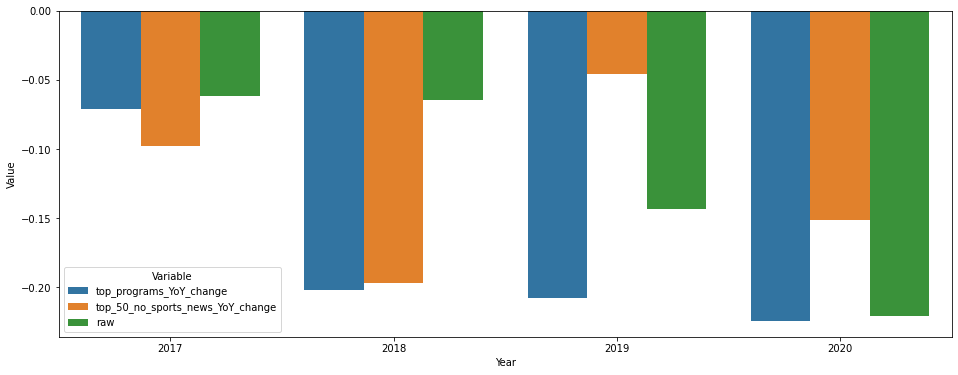

In [8]:
tidy = year_stats.melt(id_vars='year').rename(columns=str.title)
plt.figure(figsize=(16, 6))
fig = sns.barplot(x='Year', y='Value', hue='Variable', data=tidy)

In [9]:
plot = df.groupby(['year', 'program', 'category'])['viewers'].agg(avg_rating='mean', episodes='count').reset_index()
plot[plot['year'] == 2017].sort_values('avg_rating', ascending=False).to_csv('2017.csv', index=False)

In [10]:
df.to_csv('merged.csv', index=False)